# Imports

In [1]:
import scipy.io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time # spooky

RNDS = 1389

# Data

In [2]:
mat_data = scipy.io.loadmat('./data/mnistAll.mat')
mnist_data = mat_data['mnist']

In [3]:
# load images
train_images = mnist_data['train_images'][0, 0].T.squeeze()
test_images = mnist_data['test_images'][0, 0].T.squeeze()
train_labels = mnist_data['train_labels'][0, 0].T.squeeze()
test_labels = mnist_data['test_labels'][0, 0].T.squeeze()
# find idxs that are of 3 and 7
train_filter = np.where((train_labels == 3) | (train_labels == 7))[0].squeeze()
test_filter = np.where((test_labels == 3) | (test_labels == 7))[0]

# filter only images and labels of 3 and 7
train_images = train_images[train_filter]
train_labels = train_labels[train_filter]
test_images = test_images[test_filter]
test_labels = test_labels[test_filter]

# split train into train and val
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=RNDS)


print(train_images.shape, val_images.shape, test_images.shape, train_labels.shape, val_labels.shape, test_labels.shape)

(9916, 28, 28) (2480, 28, 28) (2038, 28, 28) (9916,) (2480,) (2038,)


In [4]:
# scale inputs to be between 0 and 1
train_images = train_images.astype(float) / 255.0 # 255 because greyscale images
val_images = val_images.astype(float) / 255.0
test_images = test_images.astype(float) / 255.0

# scale classes to be 0 and 1 as well
train_labels = np.where(train_labels == 3, 0, 1)
val_labels = np.where(val_labels == 3, 0, 1)
test_labels = np.where(test_labels == 3, 0, 1)

## Setup 

In [5]:
# sigmoid function
def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

# predict function
def predict(x, w):
    return sigma(np.dot(x, w))

# negative log likelihood
def NLL(y_pred, t):
    # clip the predicted values to avoid taking the logarithm of 0 or 1
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(t * np.log(y_pred) + (1 - t) * np.log(1 - y_pred))

# gradient with respect to weights
def gradient(x, y_pred, t):
    return np.dot(x.T, (y_pred - t)) / len(x)

def misclassification_rate(y_pred, t):
    # convert predictions to binary labels
    y_labels = (y_pred >= 0.5).astype(int)
    return np.mean(y_labels != t)

# set random seed for reproducibility
np.random.seed(RNDS)

# flatten and add a bias term to the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

train_images_bias = np.c_[np.ones((train_images_flat.shape[0], 1)), train_images_flat]
val_images_bias = np.c_[np.ones((val_images_flat.shape[0], 1)), val_images_flat]
test_images_bias = np.c_[np.ones((test_images_flat.shape[0], 1)), test_images_flat]

# random initial weights
w_init = np.random.randn(train_images_bias.shape[1])

learning_rates = [0.001, 0.01, 0.1]

## Gradient descent

In [6]:
# gradient descent training with early stopping
def train(x, t, w, learning_rate, epochs, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad = gradient(x, y_pred, t)
        w -= learning_rate * grad
    
    return w, train_errors, val_errors, best_train_error, best_val_error

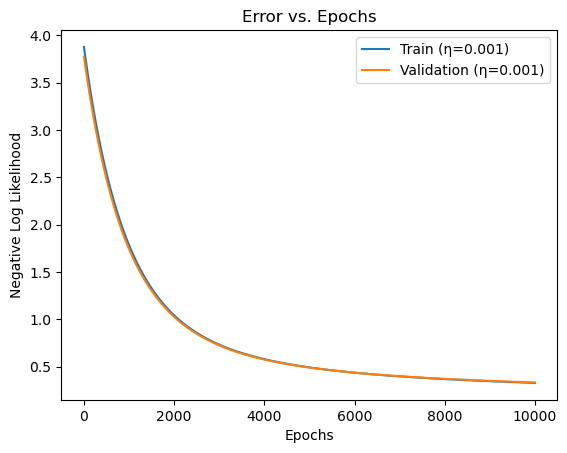

Best training error with learning rate 0.001: 0.32784502849393227
Best validation error with learning rate 0.001: 0.3327462085034984
Test error with learning rate 0.001: 0.34687764437703805
Training misclassification rate: 0.08884630899556273
Validation misclassification rate: 0.08629032258064516
Test misclassification rate: 0.08194308145240432
Training time for learning rate 0.001: 66.3047411441803 seconds


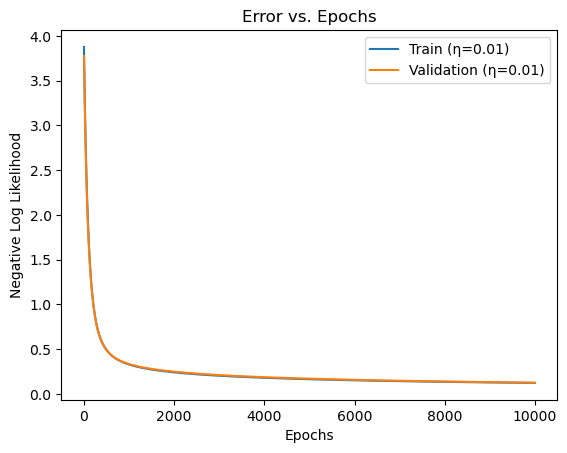

Best training error with learning rate 0.01: 0.12199507427493922
Best validation error with learning rate 0.01: 0.1244922575758461
Test error with learning rate 0.01: 0.1592400456497732
Training misclassification rate: 0.03227107704719645
Validation misclassification rate: 0.03467741935483871
Test misclassification rate: 0.03876349362119725
Training time for learning rate 0.01: 60.89005208015442 seconds


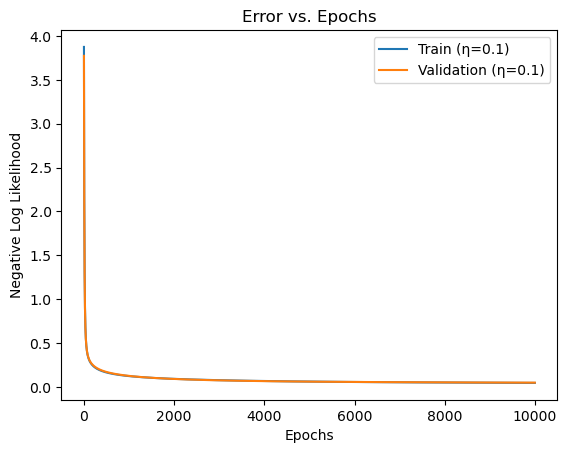

Best training error with learning rate 0.1: 0.044425517165283916
Best validation error with learning rate 0.1: 0.04758616564187317
Test error with learning rate 0.1: 0.07046595561086608
Training misclassification rate: 0.01300927793465107
Validation misclassification rate: 0.01532258064516129
Test misclassification rate: 0.020608439646712464
Training time for learning rate 0.1: 62.20416736602783 seconds


In [7]:
# training loop
for eta in learning_rates:
    start_time = time.time()
    
    w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 10000, val_images_bias, val_labels)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    plt.plot(train_errors, label=f'Train (η={eta})')
    plt.plot(val_errors, label=f'Validation (η={eta})')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Error vs. Epochs')
    plt.show()
    
    y_train_pred = predict(train_images_bias, w)
    train_misclass_rate = misclassification_rate(y_train_pred, train_labels)
    
    y_val_pred = predict(val_images_bias, w)
    val_misclass_rate = misclassification_rate(y_val_pred, val_labels)
    
    y_test_pred = predict(test_images_bias, w)
    test_error = NLL(y_test_pred, test_labels)
    test_misclass_rate = misclassification_rate(y_test_pred, test_labels)
    
    print(f"Best training error with learning rate {eta}: {best_train_error}")
    print(f"Best validation error with learning rate {eta}: {best_val_error}")
    print(f"Test error with learning rate {eta}: {test_error}")
    print(f"Training misclassification rate: {train_misclass_rate}")
    print(f"Validation misclassification rate: {val_misclass_rate}")
    print(f"Test misclassification rate: {test_misclass_rate}")
    print(f"Training time for learning rate {eta}: {elapsed_time} seconds")

## Momentum

In [8]:
# redefine the gradient function to include momentum
def gradient_momentum(x, y_pred, t, prev_delta_w, alpha):
    grad = np.dot(x.T, (y_pred - t)) / len(x)
    delta_w = -grad + alpha * prev_delta_w # gradient term
    return delta_w

In [9]:
# redefine the train function
def train_momentum(x, t, w, learning_rate, epochs, alpha, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    prev_delta_w = np.zeros_like(w)
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        delta_w = gradient_momentum(x, y_pred, t, prev_delta_w, alpha)
        w += learning_rate * delta_w
        prev_delta_w = delta_w
    
    return w, train_errors, val_errors, best_train_error, best_val_error

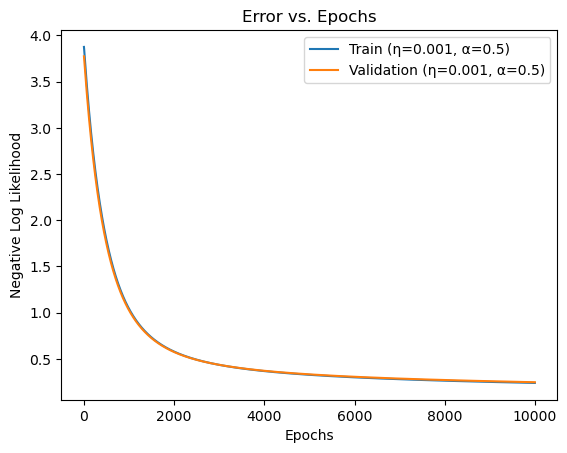

Best training error with (η=0.001, α=0.5): 0.24006703674663
Best validation error with (η=0.001, α=0.5): 0.24760487792550723
Test error with (η=0.001, α=0.5): 0.277105228955694
Training misclassification rate: 0.06524808390480032
Validation misclassification rate: 0.06491935483870968
Test misclassification rate: 0.06820412168792934
Training time (η=0.001, α=0.5): 63.18899989128113 seconds


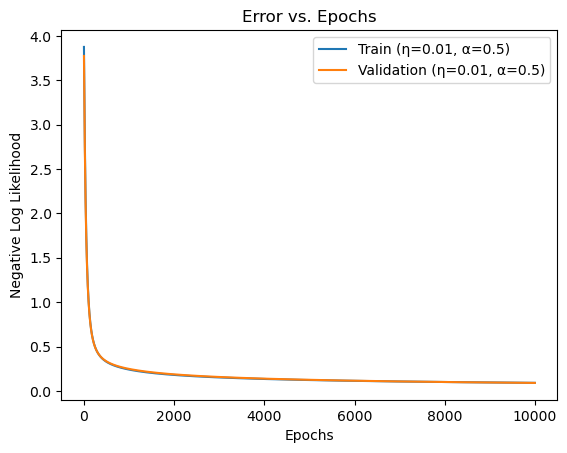

Best training error with (η=0.01, α=0.5): 0.09058181462715975
Best validation error with (η=0.01, α=0.5): 0.0895997830351151
Test error with (η=0.01, α=0.5): 0.12198842256652917
Training misclassification rate: 0.024203307785397338
Validation misclassification rate: 0.025806451612903226
Test misclassification rate: 0.030912659470068694
Training time (η=0.01, α=0.5): 65.87959170341492 seconds


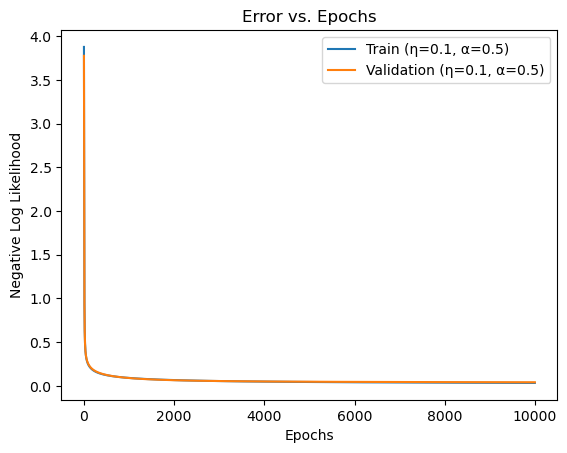

Best training error with (η=0.1, α=0.5): 0.03394503224581753
Best validation error with (η=0.1, α=0.5): 0.04149021740073238
Test error with (η=0.1, α=0.5): 0.06328058376527157
Training misclassification rate: 0.010891488503428802
Validation misclassification rate: 0.014516129032258065
Test misclassification rate: 0.019627085377821395
Training time (η=0.1, α=0.5): 65.22447085380554 seconds


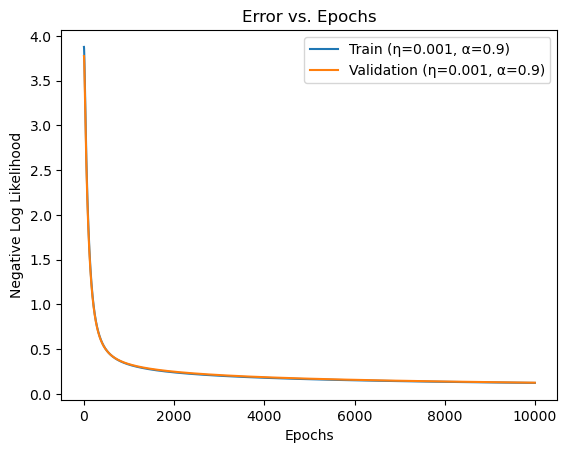

Best training error with (η=0.001, α=0.9): 0.12215741960882923
Best validation error with (η=0.001, α=0.9): 0.12468071881692333
Test error with (η=0.001, α=0.9): 0.15952237434311775
Training misclassification rate: 0.03227107704719645
Validation misclassification rate: 0.03467741935483871
Test misclassification rate: 0.03876349362119725
Training time (η=0.001, α=0.9): 64.40013337135315 seconds


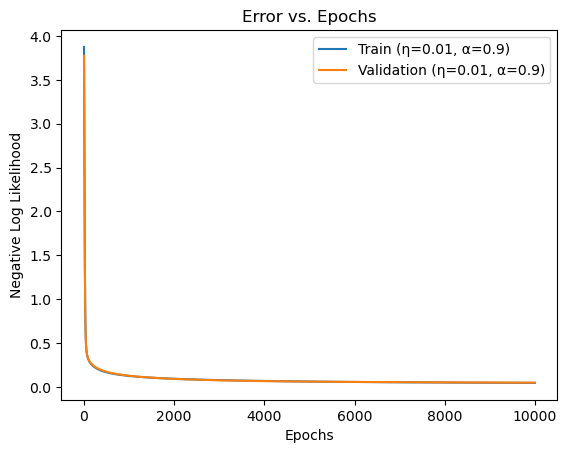

Best training error with (η=0.01, α=0.9): 0.04458831661301077
Best validation error with (η=0.01, α=0.9): 0.04772586704603971
Test error with (η=0.01, α=0.9): 0.07073025522909539
Training misclassification rate: 0.013110125050423558
Validation misclassification rate: 0.01532258064516129
Test misclassification rate: 0.020608439646712464
Training time (η=0.01, α=0.9): 66.26962232589722 seconds


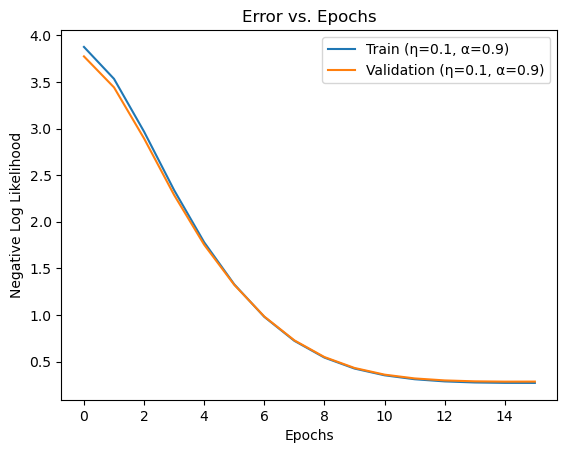

Best training error with (η=0.1, α=0.9): 0.27034154226835816
Best validation error with (η=0.1, α=0.9): 0.28424670283657844
Test error with (η=0.1, α=0.9): 0.34400948091877265
Training misclassification rate: 0.058592174263816056
Validation misclassification rate: 0.06129032258064516
Test misclassification rate: 0.06035328753680078
Training time (η=0.1, α=0.9): 0.10500073432922363 seconds


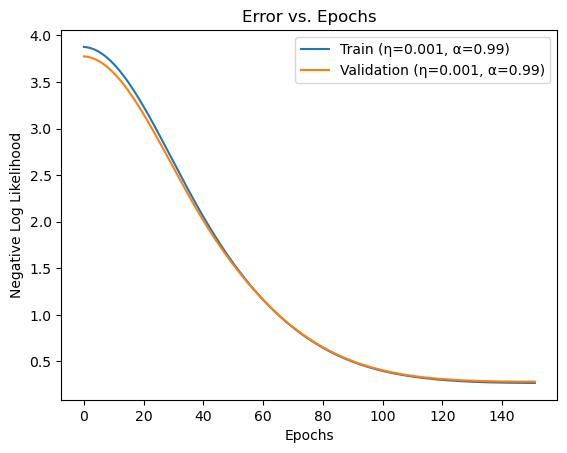

Best training error with (η=0.001, α=0.99): 0.2691595372012836
Best validation error with (η=0.001, α=0.99): 0.2829088469071293
Test error with (η=0.001, α=0.99): 0.3382220305392126
Training misclassification rate: 0.05788624445340863
Validation misclassification rate: 0.06088709677419355
Test misclassification rate: 0.061334641805691856
Training time (η=0.001, α=0.99): 1.0510010719299316 seconds


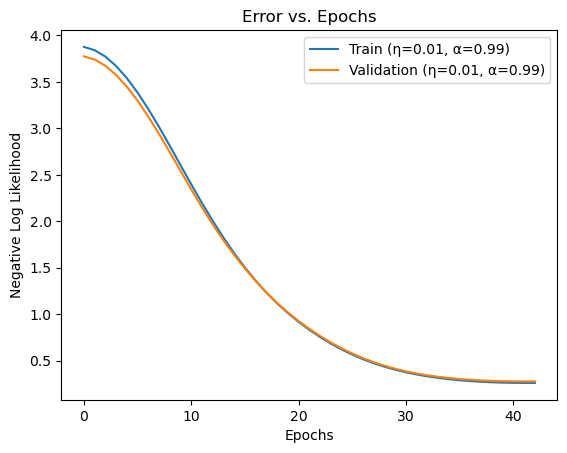

Best training error with (η=0.01, α=0.99): 0.2609226328459017
Best validation error with (η=0.01, α=0.99): 0.2770668141740353
Test error with (η=0.01, α=0.99): 0.3409749268298889
Training misclassification rate: 0.050322710770471964
Validation misclassification rate: 0.05241935483870968
Test misclassification rate: 0.05299313052011776
Training time (η=0.01, α=0.99): 0.2929980754852295 seconds


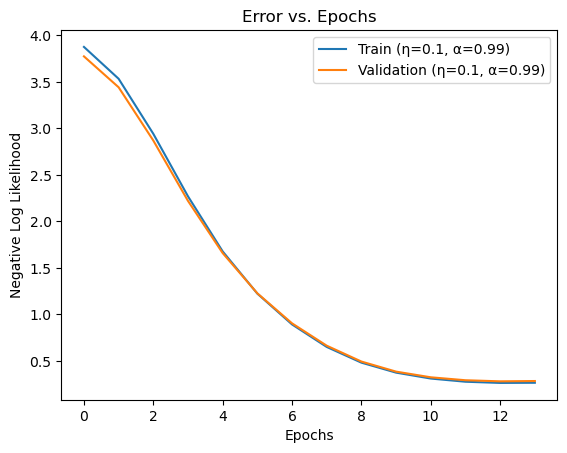

Best training error with (η=0.1, α=0.99): 0.2631245716818635
Best validation error with (η=0.1, α=0.99): 0.2802048654268888
Test error with (η=0.1, α=0.99): 0.35678798711300497
Training misclassification rate: 0.04739814441306978
Validation misclassification rate: 0.04838709677419355
Test misclassification rate: 0.04857703631010795
Training time (η=0.1, α=0.99): 0.0970005989074707 seconds


In [10]:
# training loop
momentums = [0.5, 0.9, 0.99]

for alpha in momentums:
    for eta in learning_rates:
        start_time = time.time()
    
        w, train_errors, val_errors, best_train_error, best_val_error = train_momentum(train_images_bias, train_labels, w_init.copy(), eta, 10000, alpha, val_images_bias, val_labels)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
    
        plt.plot(train_errors, label=f'Train (η={eta}, α={alpha})')
        plt.plot(val_errors, label=f'Validation (η={eta}, α={alpha})')
        plt.xlabel('Epochs')
        plt.ylabel('Negative Log Likelihood')
        plt.legend()
        plt.title('Error vs. Epochs')
        plt.show()
    
        y_train_pred = predict(train_images_bias, w)
        train_misclass_rate = misclassification_rate(y_train_pred, train_labels)
    
        y_val_pred = predict(val_images_bias, w)
        val_misclass_rate = misclassification_rate(y_val_pred, val_labels)
    
        y_test_pred = predict(test_images_bias, w)
        test_error = NLL(y_test_pred, test_labels)
        test_misclass_rate = misclassification_rate(y_test_pred, test_labels)
    
        print(f"Best training error with (η={eta}, α={alpha}): {best_train_error}")
        print(f"Best validation error with (η={eta}, α={alpha}): {best_val_error}")
        print(f"Test error with (η={eta}, α={alpha}): {test_error}")
        print(f"Training misclassification rate: {train_misclass_rate}")
        print(f"Validation misclassification rate: {val_misclass_rate}")
        print(f"Test misclassification rate: {test_misclass_rate}")
        print(f"Training time (η={eta}, α={alpha}): {elapsed_time} seconds")

## Weight Decay

In [11]:
# redefine gradient
def gradient_weight_decay(x, y_pred, t, w, prev_delta_w, alpha, lmbda):
    nll_gradient = np.dot(x.T, (y_pred - t)) / len(x) 
    regularization_term = lmbda* w / x.shape[1]
    momentum_term = alpha * prev_delta_w 
    delta_w = -nll_gradient + regularization_term + momentum_term
    return delta_w

In [12]:
def train_weight_decay(x, t, w, learning_rate, epochs, alpha, lmbda, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    prev_delta_w = np.zeros_like(w)
    
    for _ in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        delta_w = gradient_weight_decay(x, y_pred, t, w, prev_delta_w, alpha, lmbda)
        w += learning_rate * delta_w
        prev_delta_w = delta_w
    
    return w, train_errors, val_errors, best_train_error, best_val_error

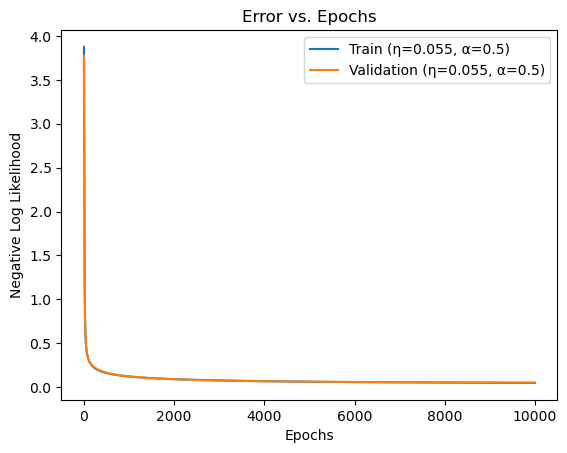

Best training error with (η=0.055, α=0.5): 0.04608934951098934
Best validation error with (η=0.055, α=0.5): 0.050270987477338325
Test error with (η=0.055, α=0.5): 0.0753218254202345
Training misclassification rate: 0.013110125050423558
Validation misclassification rate: 0.014919354838709677
Test misclassification rate: 0.021589793915603533
Training time (η=0.055, α=0.5): 67.28911352157593 seconds


In [13]:
# training loop
alpha = 0.5
lmbda = .1

# for eta in learning_rates:

eta = 0.055
start_time = time.time()

w, train_errors, val_errors, best_train_error, best_val_error = train_weight_decay(train_images_bias, train_labels, w_init.copy(), eta,
                                                                                    10000, alpha, lmbda, val_images_bias, val_labels)

end_time = time.time()
elapsed_time = end_time - start_time

plt.plot(train_errors, label=f'Train (η={eta}, α={alpha})')
plt.plot(val_errors, label=f'Validation (η={eta}, α={alpha})')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Error vs. Epochs')
plt.show()

y_train_pred = predict(train_images_bias, w)
train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

y_val_pred = predict(val_images_bias, w)
val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

y_test_pred = predict(test_images_bias, w)
test_error = NLL(y_test_pred, test_labels)
test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

print(f"Best training error with (η={eta}, α={alpha}): {best_train_error}")
print(f"Best validation error with (η={eta}, α={alpha}): {best_val_error}")
print(f"Test error with (η={eta}, α={alpha}): {test_error}")
print(f"Training misclassification rate: {train_misclass_rate}")
print(f"Validation misclassification rate: {val_misclass_rate}")
print(f"Test misclassification rate: {test_misclass_rate}")
print(f"Training time (η={eta}, α={alpha}): {elapsed_time} seconds")

## Newton Method

In [14]:
# redefine  predict function
# def predict(x, w):
#     return sigma(np.clip(x @ w, -250, 250))

# redefine gradient
def gradient(x, y_pred, t, lmbda, w):
    nll_gradient = np.dot(x.T, (y_pred - t))
    regularization_gradient = lmbda * w
    return nll_gradient + regularization_gradient

def hessian(X, y_pred, lmbda):
    R = np.diag(y_pred * (1 - y_pred))
    H = (X.T @ R @ X) + lmbda * np.eye(X.shape[1]) # maybe divide left part by len(X) here?
    return H

In [15]:
# redefine train
def train_newton(x, t, w, epochs, eta, lmbda, x_val=None, t_val=None):
    train_errors = []
    val_errors = []

    best_train_error = float('inf')
    best_val_error = float('inf')

    for _ in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad = gradient(x, y_pred, t, lmbda, w) # w = (785 x 1), 785 = 28 x 28 + 1
        H = hessian(x, y_pred, lmbda)
        delta_w = - eta * np.linalg.solve(H, grad)
        w += delta_w

    return w, train_errors, val_errors, best_train_error, best_val_error

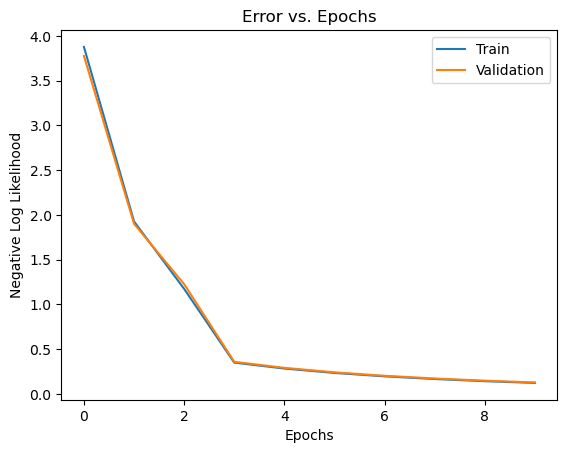

Best training error: 0.12206636504999736
Best validation error: 0.12734979095448787
Test error: 0.10768293273877086
Training misclassification rate: 0.01189995966115369
Validation misclassification rate: 0.01532258064516129
Test misclassification rate: 0.01521099116781158
Training time: 10.645005941390991 seconds


In [16]:
# training loop
lmbda = 5
n_epochs = 10
eta = .2

start_time = time.time()

w, train_errors, val_errors, best_train_error, best_val_error = train_newton(train_images_bias, train_labels, w_init.copy(), n_epochs, eta, lmbda, val_images_bias, val_labels)

end_time = time.time()
elapsed_time = end_time - start_time

plt.plot(train_errors, label=f'Train')
plt.plot(val_errors, label=f'Validation')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Error vs. Epochs')
plt.show()

y_train_pred = predict(train_images_bias, w)
train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

y_val_pred = predict(val_images_bias, w)
val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

y_test_pred = predict(test_images_bias, w)
test_error = NLL(y_test_pred, test_labels)
test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

print(f"Best training error: {best_train_error}")
print(f"Best validation error: {best_val_error}")
print(f"Test error: {test_error}")
print(f"Training misclassification rate: {train_misclass_rate}")
print(f"Validation misclassification rate: {val_misclass_rate}")
print(f"Test misclassification rate: {test_misclass_rate}")
print(f"Training time: {elapsed_time} seconds")

## Line Search

In [17]:
# use the original gradient function
def gradient(x, y_pred, t):
    return np.dot(x.T, (y_pred - t)) / len(x)

def line_search(w, d, x, t, init_gamma=0.001, max_iters=100, gamma_scale=1.1):
    best_gamma = init_gamma
    best_error = float('inf')
    
    gamma = init_gamma
    for i in range(max_iters):
        w_try = w + gamma * d
        y_pred = predict(x, w_try)
        error = NLL(y_pred, t)
        
        if error < best_error:
            best_error = error
            best_gamma = gamma
        else:
            break
        
        gamma *= gamma_scale
    
    return best_gamma

In [18]:
def train_ls(x, t, w, learning_rate, epochs, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad = gradient(x, y_pred, t)
        optimal_lr = line_search(w, -grad, x, t)
        w -= optimal_lr * grad
    
    return w, train_errors, val_errors, best_train_error, best_val_error

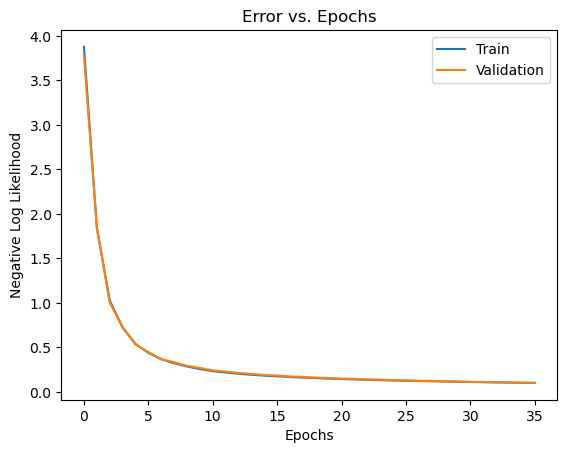

Best training error: 0.10115969193650216
Best validation error: 0.10262695280237122
Test error: 0.1319526758982514
Training misclassification rate: 0.02581686163775716
Validation misclassification rate: 0.028629032258064516
Test misclassification rate: 0.03189401373895977
Training time: 9.511740922927856 seconds


In [19]:
# training loop
start_time = time.time()
eta = 0 # this variable isn't used, this is for backwards compatibility (not really)

w, train_errors, val_errors, best_train_error, best_val_error = train_ls(train_images_bias, train_labels, w_init.copy(), eta, 224, val_images_bias, val_labels)

end_time = time.time()
elapsed_time = end_time - start_time

plt.plot(train_errors, label=f'Train')
plt.plot(val_errors, label=f'Validation')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Error vs. Epochs')
plt.show()

y_train_pred = predict(train_images_bias, w)
train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

y_val_pred = predict(val_images_bias, w)
val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

y_test_pred = predict(test_images_bias, w)
test_error = NLL(y_test_pred, test_labels)
test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

print(f"Best training error: {best_train_error}")
print(f"Best validation error: {best_val_error}")
print(f"Test error: {test_error}")
print(f"Training misclassification rate: {train_misclass_rate}")
print(f"Validation misclassification rate: {val_misclass_rate}")
print(f"Test misclassification rate: {test_misclass_rate}")
print(f"Training time: {elapsed_time} seconds")

## Conjugate Gradient Descent

Polak-Ribiere:
$\beta = \frac{\nabla E(w_{new})^T (\nabla E(w_{new}) - \nabla E(w_{old}))}{||\nabla E(w_{old})||^2}$
<br>
Update rule for $d$:
$d_{new} = -\nabla E(w_{new}) + \beta d_{old}$

In [20]:
# we only need to update the training function from line search
def train_cgd(x, t, w, epochs, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    d_old = np.zeros_like(w) # initialise the old direction as zeros
    grad_old = gradient(x, predict(x, w), t) # initialise the old gradient

    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad_new = gradient(x, y_pred, t)

        # Polak-Ribiere rule
        beta = np.dot(grad_new, grad_new - grad_old) / np.dot(grad_old, grad_old)
        # get new direction
        d_new = -grad_new + beta * d_old
        # line search to get optimal learning rate for this direction
        optimal_lr = line_search(w, d_new, x, t)
        
        # update weights
        w += optimal_lr * d_new

        # store current gradient and direction for the next iteration
        grad_old = grad_new
        d_old = d_new

    return w, train_errors, val_errors, best_train_error, best_val_error

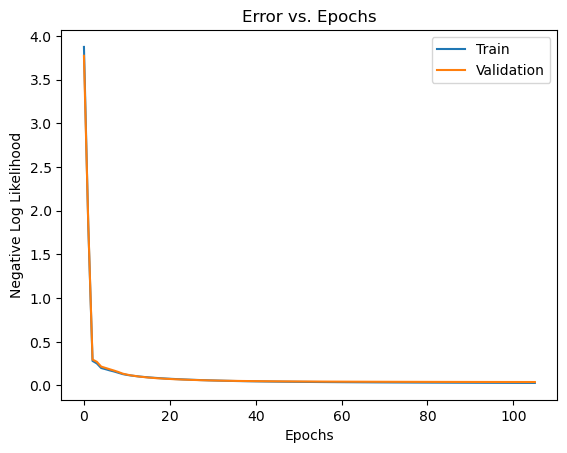

Best training error: 0.02940770291785119
Best validation error: 0.03976088233398225
Test error: 0.06215521252148617
Training misclassification rate: 0.00927793465106898
Validation misclassification rate: 0.013306451612903225
Test misclassification rate: 0.019627085377821395
Training time: 30.42300248146057 seconds


In [21]:
# training loop
start_time = time.time()

w, train_errors, val_errors, best_train_error, best_val_error = train_cgd(train_images_bias, train_labels, w_init.copy(), 106, val_images_bias, val_labels)

end_time = time.time()
elapsed_time = end_time - start_time

plt.plot(train_errors, label=f'Train')
plt.plot(val_errors, label=f'Validation')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Error vs. Epochs')
plt.show()

y_train_pred = predict(train_images_bias, w)
train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

y_val_pred = predict(val_images_bias, w)
val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

y_test_pred = predict(test_images_bias, w)
test_error = NLL(y_test_pred, test_labels)
test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

print(f"Best training error: {best_train_error}")
print(f"Best validation error: {best_val_error}")
print(f"Test error: {test_error}")
print(f"Training misclassification rate: {train_misclass_rate}")
print(f"Validation misclassification rate: {val_misclass_rate}")
print(f"Test misclassification rate: {test_misclass_rate}")
print(f"Training time: {elapsed_time} seconds")

## Stochastic Gradient Descent

In [22]:
def gradient(x, y_pred, t):
    return np.dot(x.T, (y_pred - t)) / len(x)

# gradient descent training with early stopping
def train(x, t, w, learning_rate, epochs, batch_size, x_val=None, t_val=None):
    x_batches = np.array_split(x, batch_size)
    t_batches = np.array_split(t, batch_size)
    combined = list(zip(x_batches, t_batches))

    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    for epoch in range(epochs):
        np.random.shuffle(combined)

        batch_train_errors = []
        for x_batch, t_batch in combined:
            y_pred = predict(x_batch, w)

            grad = gradient(x_batch, y_pred, t_batch)
            w -= learning_rate * grad

        # total train error for plotting
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        best_train_error = min(best_train_error, current_train_error)

        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)

            # early stopping
            if current_val_error > best_val_error:
                break

        best_val_error = min(best_val_error, current_val_error)

        
    
    return w, train_errors, val_errors, best_train_error, best_val_error

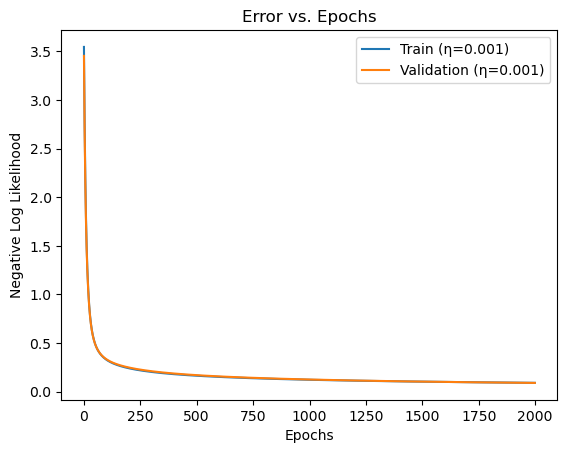

Best training error with learning rate 0.001: 0.09094992812841052
Best validation error with learning rate 0.001: 0.090004514357784
Test error with learning rate 0.001: 0.12240322854068933
Training misclassification rate: 0.024405002016942314
Validation misclassification rate: 0.025806451612903226
Test misclassification rate: 0.030912659470068694
Training time for learning rate 0.001: 19.949999809265137 seconds


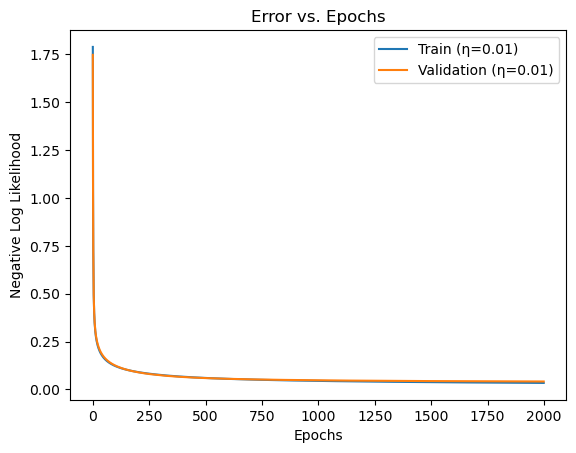

Best training error with learning rate 0.01: 0.03405085592827821
Best validation error with learning rate 0.01: 0.04152920015246604
Test error with learning rate 0.01: 0.0632854389561739
Training misclassification rate: 0.010992335619201292
Validation misclassification rate: 0.014516129032258065
Test misclassification rate: 0.019627085377821395
Training time for learning rate 0.01: 20.301002025604248 seconds


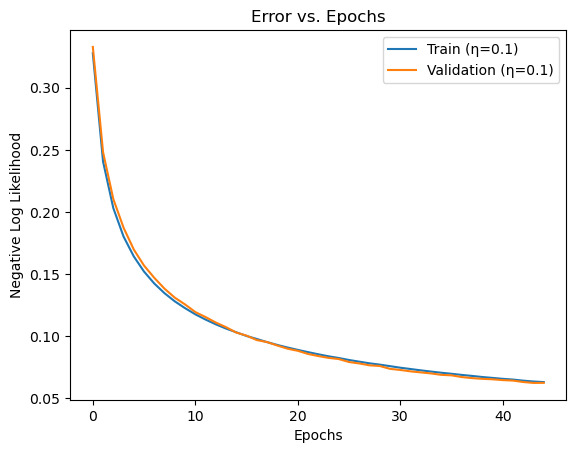

Best training error with learning rate 0.1: 0.06309002794478027
Best validation error with learning rate 0.1: 0.06241100518603617
Test error with learning rate 0.1: 0.08801859431191776
Training misclassification rate: 0.01855586930213796
Validation misclassification rate: 0.01975806451612903
Test misclassification rate: 0.025024533856722278
Training time for learning rate 0.1: 0.4250009059906006 seconds


In [23]:
batch_size = int(0.01 * len(train_images_bias))

# training loop
for eta in learning_rates:
    start_time = time.time()
    
    w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 2000, batch_size, val_images_bias, val_labels)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    plt.plot(train_errors, label=f'Train (η={eta})')
    plt.plot(val_errors, label=f'Validation (η={eta})')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Error vs. Epochs')
    plt.show()
    
    y_train_pred = predict(train_images_bias, w)
    train_misclass_rate = misclassification_rate(y_train_pred, train_labels)
    
    y_val_pred = predict(val_images_bias, w)
    val_misclass_rate = misclassification_rate(y_val_pred, val_labels)
    
    y_test_pred = predict(test_images_bias, w)
    test_error = NLL(y_test_pred, test_labels)
    test_misclass_rate = misclassification_rate(y_test_pred, test_labels)
    
    print(f"Best training error with learning rate {eta}: {best_train_error}")
    print(f"Best validation error with learning rate {eta}: {best_val_error}")
    print(f"Test error with learning rate {eta}: {test_error}")
    print(f"Training misclassification rate: {train_misclass_rate}")
    print(f"Validation misclassification rate: {val_misclass_rate}")
    print(f"Test misclassification rate: {test_misclass_rate}")
    print(f"Training time for learning rate {eta}: {elapsed_time} seconds")

## Other Datasets and Methods

Q: Discuss how the results for this problem (logisitic regression on the MNIST data) are expected to change for other data sets (more samples $N$ or more variables $n$) and methods (more variables $w$ such as deep neural networks).

If the dimensionality $n$ increases, while the number of parameters $w$ stays the same, the model will have a harder time learning the underlying distribution, because the number of parameters is not sufficient to describe the data. This could lead to overfitting, because the model will try to fit the data as well as possible, but will not be able to generalize well. 

If the number of parameters $w$ increases, while the dimensionality $n$ stays the same, the model would likely overfit on the training data, because it can fit the training data too well, resulting in poor generalization.

If there were more samples $N$, the final results would probably improve, because with more samples, the dataset is a better representation of the true data distribution, allowing the model to learn more accurately what parameter values describe the data best. This is of course only true if the samples are representative of the true data distribution. Adding samples that are not representative of the true data distribution could lead to worse results.
